In [25]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [26]:
df = pd.read_csv(f'{path}2024-12-17T16:46:34.776Z_results-ssrv-sd.csv', sep=',')
df_t = pd.read_csv(f'{path}2024-12-17T18:41:33.545Z_results-ssrv-sd-throttled.csv', sep=',')
df_ht = pd.read_csv(f'{path}2024-12-17T20:20:42.349Z_results-ssrv-sd-throttled-heavy.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']

dirty_dfs = {
    'default': df[5:],
    'throttled': df_t[5:],
    'heavy': df_ht[5:],
}

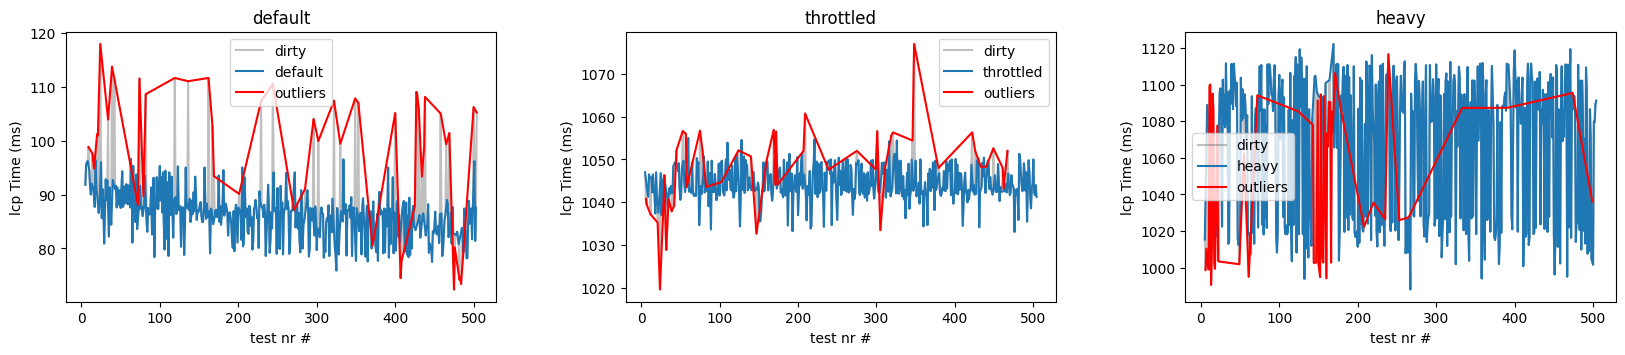

In [27]:
def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1

def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['lcp'], label='dirty', color='gray', alpha=0.5)
    loc.plot(_df['lcp'][mask[d]], label=d)
    loc.plot(_df['lcp'][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'lcp Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.legend()

masks = {}
dfs = {}
target_features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb']

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

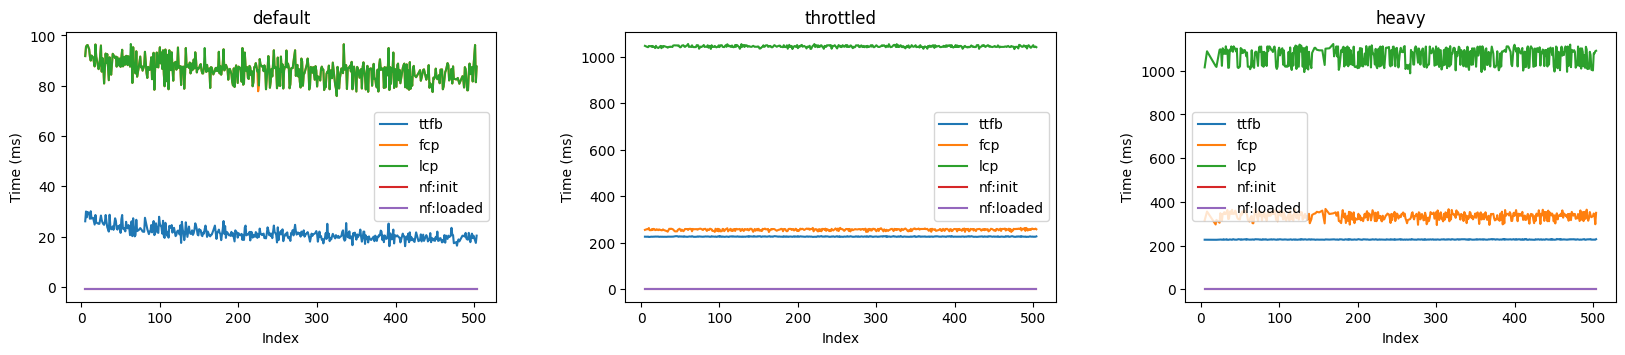

In [28]:
def plot_line(dataset, loc, idx):
    for t in ['ttfb', 'fcp', 'lcp', 'nf:init', 'nf:loaded']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

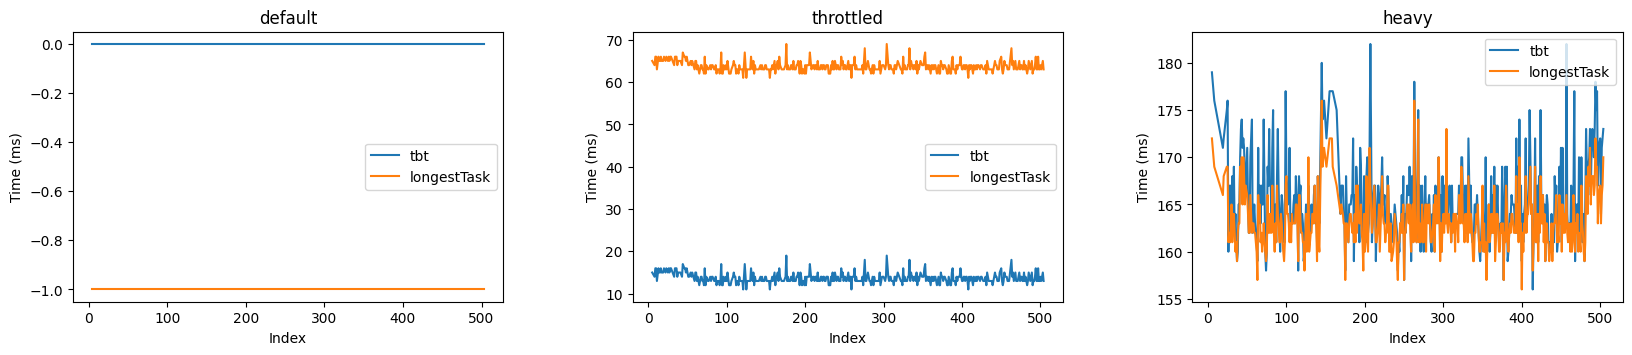

In [29]:
def plot_line(dataset, loc, idx):
    for t in ['tbt', 'longestTask']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

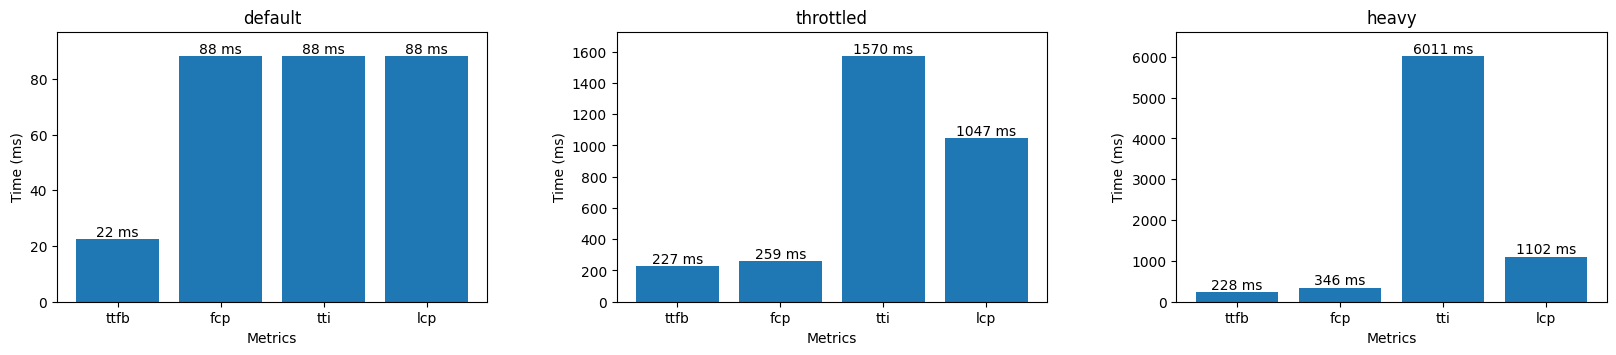

In [30]:
def plot_timeline_bars(dataset, loc, idx):
    metrics = ['ttfb', 'fcp', 'tti', 'lcp']
    quantiles = [dataset[t].quantile(0.75) for t in metrics]
    bars = loc.bar(metrics, quantiles, label='75th percentile')
    loc.set_xlabel('Metrics')
    loc.set_ylabel('Time (ms)')
    
    for bar in bars:
        height = bar.get_height()
        loc.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f} ms', ha='center', va='bottom')
    
    loc.set_ylim(0, max(quantiles) * 1.1)

graph_row(plot_timeline_bars, dfs)
plt.show()

In [31]:
dfs['default'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,252.97,26.96,83.91,86.17,86.11,21.32,0.00,86.11,0.00,-1.00,-1.00,-1.00,-1.00,NaN
std,140.84,2.76,4.12,4.23,4.20,2.49,0.00,4.20,0.00,0.00,0.00,0.00,0.00,NaN
min,6.00,21.00,74.00,75.90,75.90,16.20,0.00,75.90,0.00,-1.00,-1.00,-1.00,-1.00,NaN
25%,132.25,25.00,82.00,83.23,83.20,19.70,0.00,83.20,0.00,-1.00,-1.00,-1.00,-1.00,NaN
50%,251.50,27.00,84.00,86.70,86.70,20.90,0.00,86.70,0.00,-1.00,-1.00,-1.00,-1.00,NaN
75%,372.50,28.00,86.00,88.07,88.00,22.50,0.00,88.00,0.00,-1.00,-1.00,-1.00,-1.00,NaN
max,504.00,37.00,99.00,96.60,96.50,30.10,0.00,96.50,0.00,-1.00,-1.00,-1.00,-1.00,NaN


In [32]:
dfs['throttled'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,262.10,170.82,1574.84,1044.39,256.33,226.42,13.70,1567.31,1.00,63.70,-1.00,-1.00,-1.00,NaN
std,142.20,0.77,3.43,3.99,3.80,0.85,1.20,3.42,0.00,1.20,0.00,0.00,0.00,NaN
min,6.00,167.00,1565.00,1033.10,246.10,224.70,11.00,1558.90,1.00,61.00,-1.00,-1.00,-1.00,NaN
25%,139.25,170.00,1572.00,1042.10,253.90,225.80,13.00,1564.90,1.00,63.00,-1.00,-1.00,-1.00,NaN
50%,262.50,171.00,1574.00,1043.30,257.90,226.30,14.00,1566.15,1.00,64.00,-1.00,-1.00,-1.00,NaN
75%,384.75,171.00,1577.00,1047.27,259.10,226.90,14.00,1570.30,1.00,64.00,-1.00,-1.00,-1.00,NaN
max,505.00,174.00,1584.00,1055.00,264.00,228.90,19.00,1576.50,1.00,69.00,-1.00,-1.00,-1.00,NaN


In [33]:
dfs['heavy'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,268.54,180.05,6018.36,1066.96,334.33,227.56,165.41,6001.89,2.83,163.32,-1.00,-1.00,-1.00,NaN
std,141.43,1.01,14.20,38.77,16.38,0.89,4.41,14.17,0.39,3.03,0.00,0.00,0.00,NaN
min,6.00,178.00,5975.00,988.00,293.70,226.10,156.00,5961.10,2.00,156.00,-1.00,-1.00,-1.00,NaN
25%,138.25,179.00,6009.00,1022.47,319.80,226.80,162.00,5992.15,3.00,161.00,-1.00,-1.00,-1.00,NaN
50%,276.50,180.00,6018.00,1086.00,336.60,227.40,165.00,6001.35,3.00,163.00,-1.00,-1.00,-1.00,NaN
75%,389.75,181.00,6027.75,1101.80,345.78,228.20,167.00,6011.27,3.00,165.00,-1.00,-1.00,-1.00,NaN
max,505.00,183.00,6068.00,1122.30,367.70,230.00,182.00,6052.20,4.00,176.00,-1.00,-1.00,-1.00,NaN


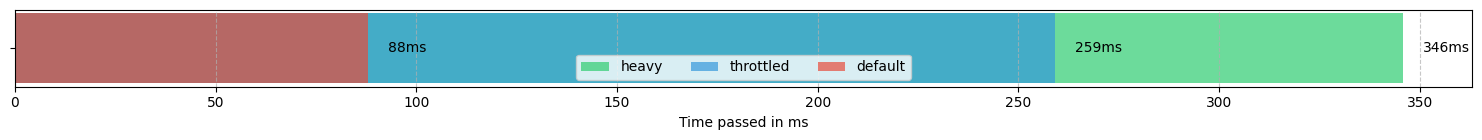

In [34]:
fig, ax = plt.subplots(figsize=(15, 1.5))

fcp_values = [df['fcp'].quantile(0.75) for df in dfs.values()]

bar_height = 0.25
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = []
for i, (name, value) in enumerate(zip(reversed(dfs.keys()), reversed(fcp_values))):
    bar = ax.barh(0.5, value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[-(i+1)]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

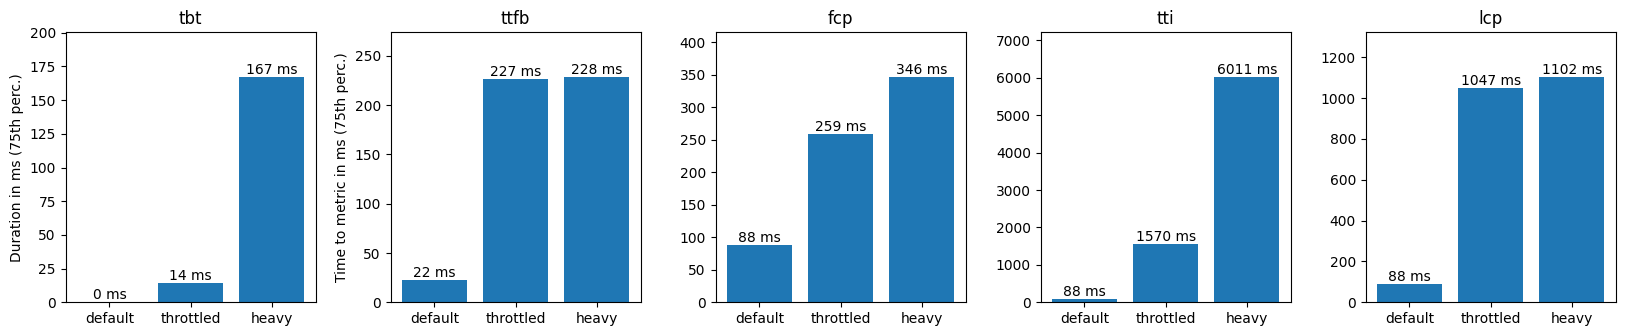

In [35]:
features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']
fig, axes = plt.subplots(ncols=len(features), figsize=(20, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

for idx, feature in enumerate(features):
    percentiles = {d: dfs[d][feature].quantile(0.75) for d in dfs.keys()}
    bars = axes[idx].bar(percentiles.keys(), percentiles.values())
    
    max_height = max(percentiles.values())
    axes[idx].set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        label = f'{int(round(height, 0))} ms'
        axes[idx].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
    
    axes[idx].set_title(feature)
    if idx == 0:
        axes[idx].set_ylabel('Duration in ms (75th perc.)')
    if idx == 1:
        axes[idx].set_ylabel('Time to metric in ms (75th perc.)')

plt.show()

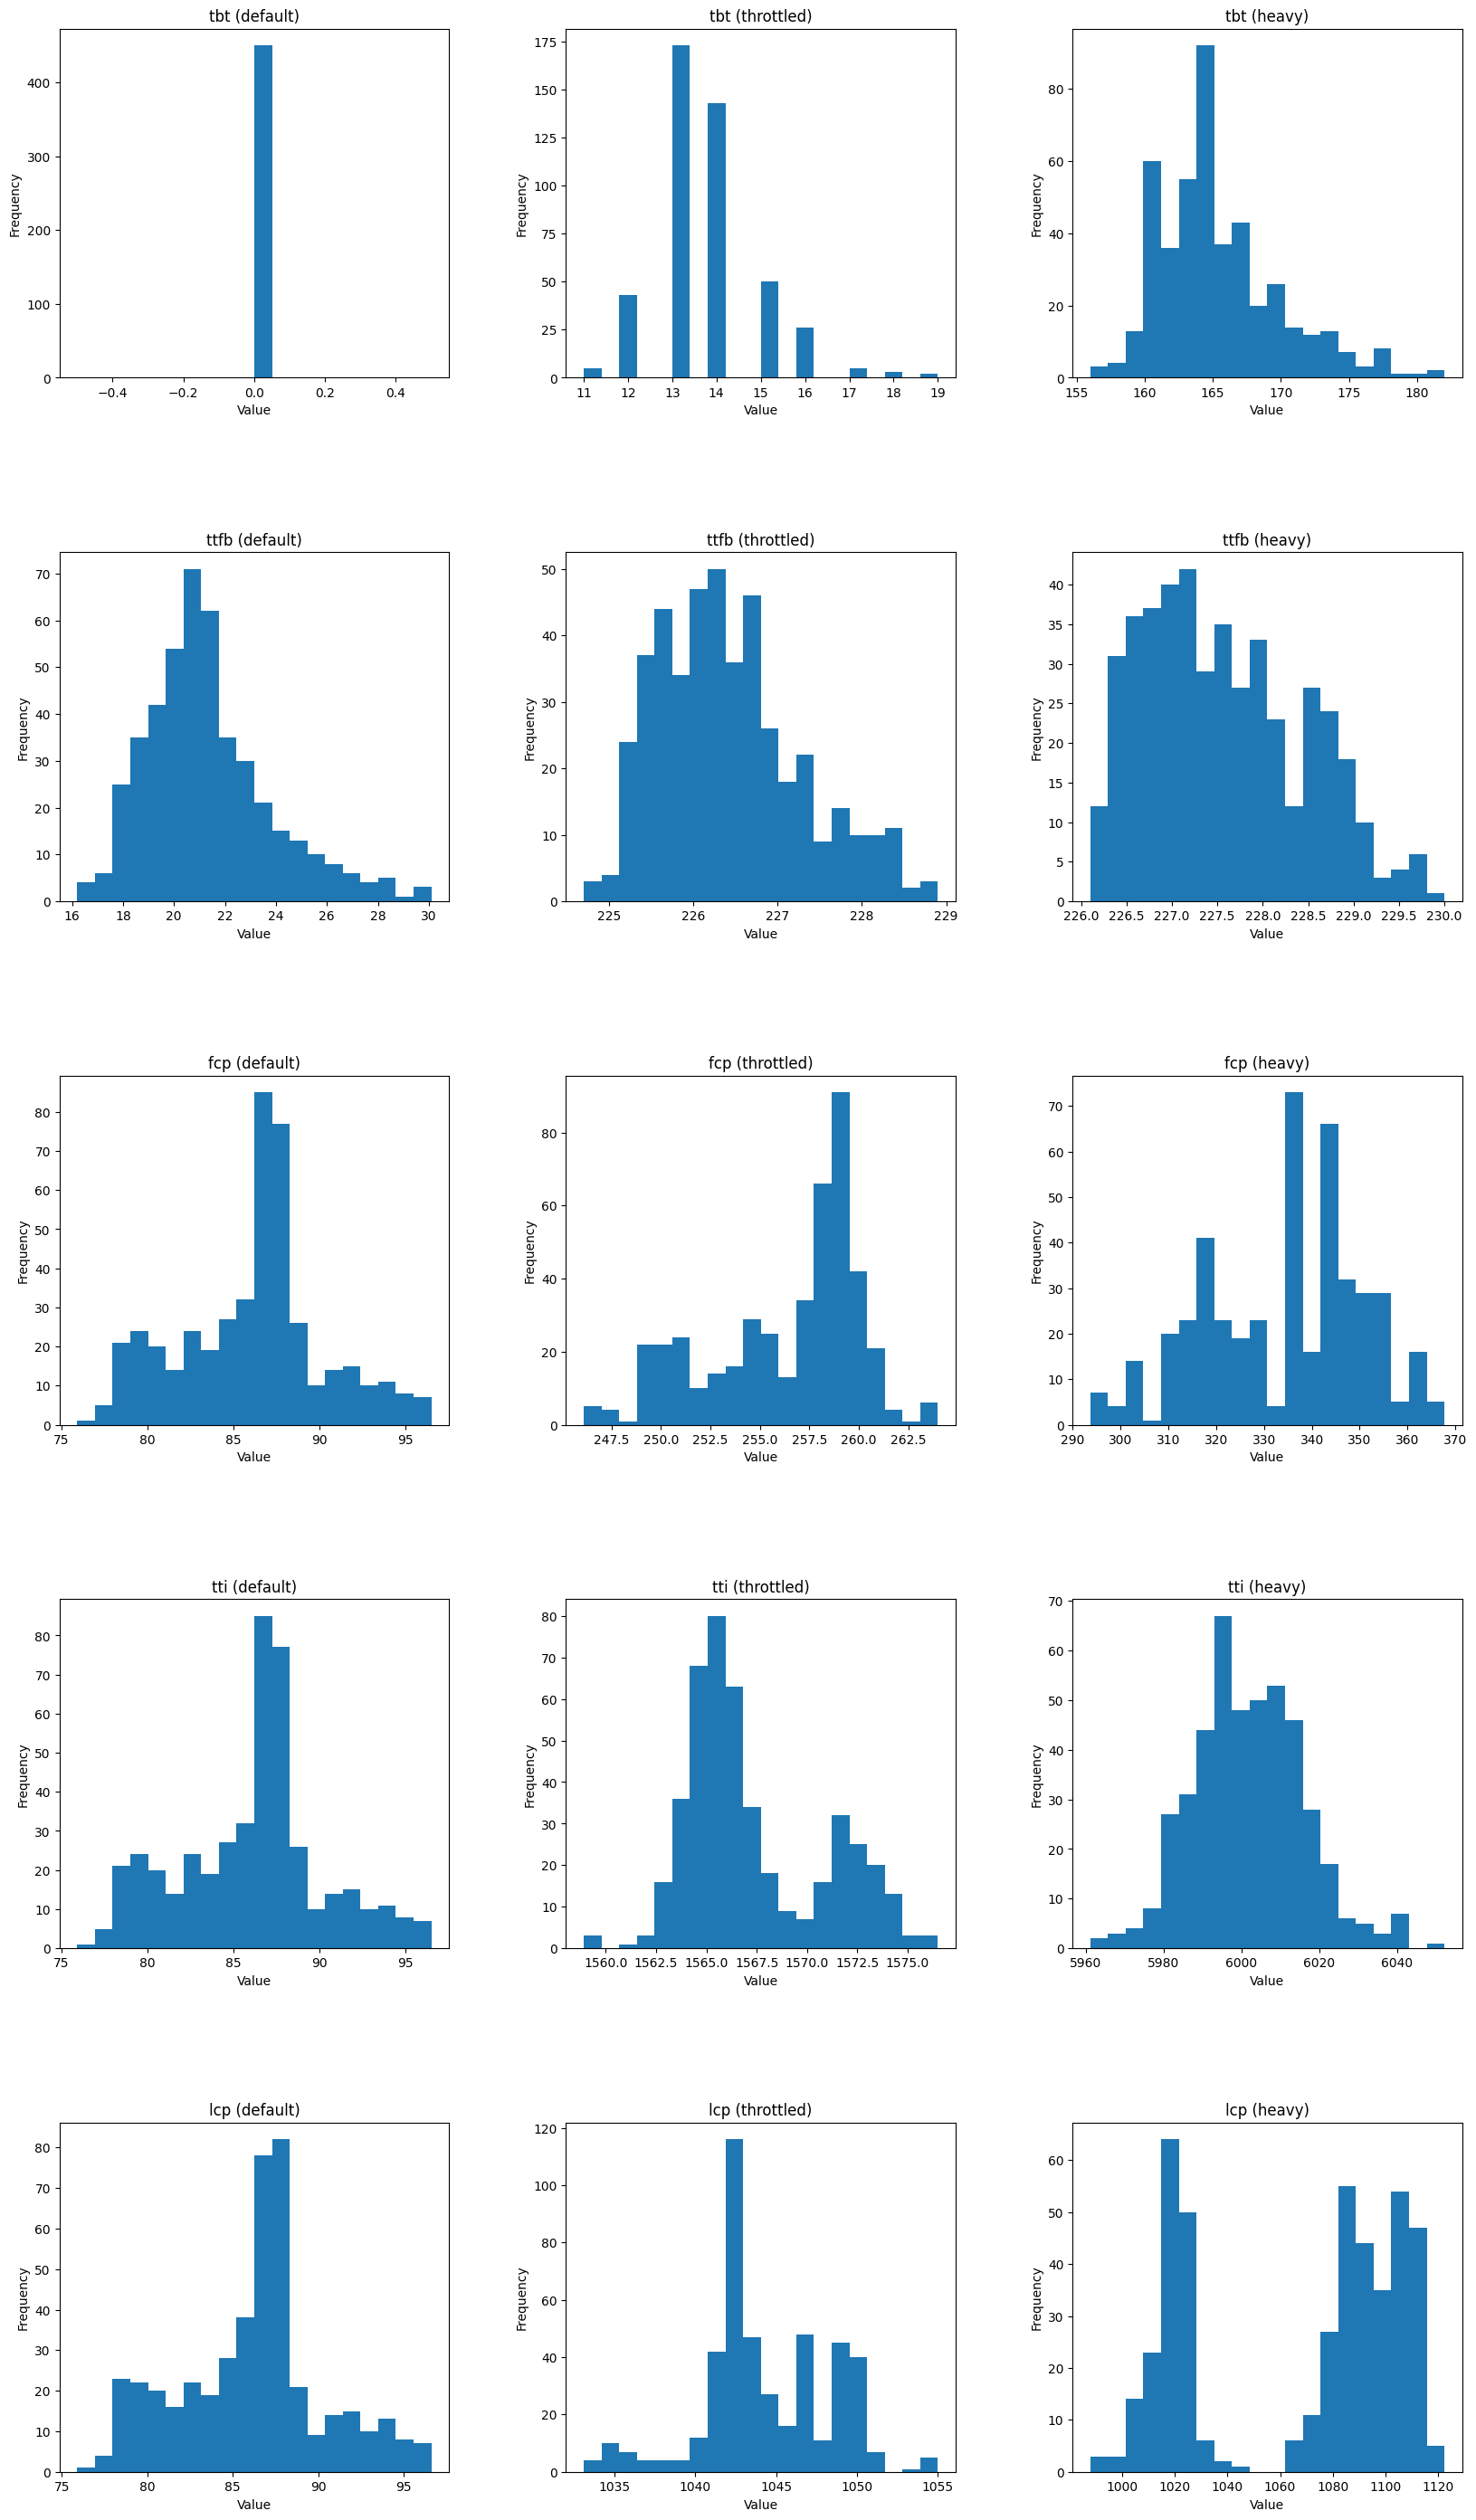

In [36]:
target_features = ['tbt', 'ttfb', 'fcp', 'tti', 'lcp']

fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        axes[y, x].hist(dfs[d][f], bins=20)
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_xlabel('Value')
        axes[y, x].set_ylabel('Frequency')

plt.show()

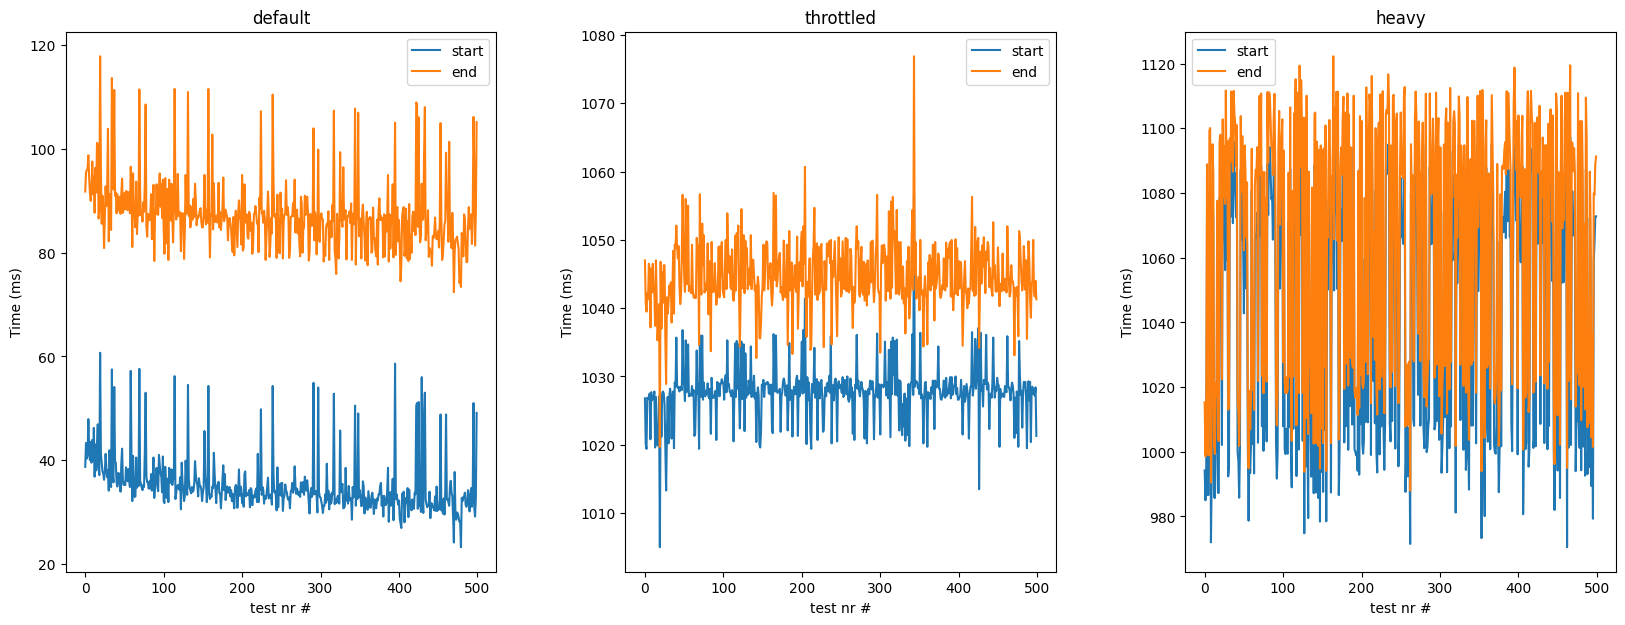

In [37]:
det_df = pd.read_csv(f'{path}details/2024-12-17T16:46:34.780Z_details-ssrv-sd.csv', sep=',')
det_df_t = pd.read_csv(f'{path}details/2024-12-17T18:41:33.550Z_details-ssrv-sd-throttled.csv', sep=',')
det_df_ht = pd.read_csv(f'{path}details/2024-12-17T20:20:42.354Z_details-ssrv-sd-throttled-heavy.csv', sep=',')

lcp_dfs = {
  'default': det_df[(det_df['type'] == 'LCP') & (det_df['idx'] > 5)].reset_index(drop=True),
  'throttled': det_df_t[(det_df_t['type'] == 'LCP') & (det_df_t['idx'] > 5)].reset_index(drop=True),
  'heavy': det_df_ht[(det_df_ht['type'] == 'LCP') & (det_df_ht['idx'] > 5)].reset_index(drop=True),
}
lcp_features = ['start','end','duration','name','element','url','id']

def plot_lcp_line(_df, loc, idx):
  for f in ['start', 'end']:
    loc.plot(_df[f], label=f)
  
  loc.set_title("LCP")
  loc.set_ylabel('Time (ms)')
  loc.set_xlabel('test nr #')
  loc.legend()

graph_row(plot_lcp_line, lcp_dfs, height=6)
plt.show()